### Downloading source ONNX model

In [1]:
import os
import urllib

In [2]:
# Model to be used for conversion.
# NOTE: it weights over 200MB. 
# To save space and internet bandwidth, 
# please change 'resnet152-v2-7' to 4 times smaller 'resnet18-v2-7'.

MODEL_NAME = 'resnet152-v2-7'

In [3]:
SRC_MODEL_FILE_NAME = MODEL_NAME + '.onnx'
SRC_MODEL_URL = os.path.join(
    'https://github.com/onnx/models/raw/master/vision/classification/resnet/model', 
    SRC_MODEL_FILE_NAME)

MODELS_PATH = './models'
DST_MODEL_FILE_NAME = 'ResNet.mlmodel'

In [4]:
def download_file(url: str, folder_path: str, skip_if_exists: bool = True):
    base_name = os.path.basename(url)
    dest_path = os.path.join(folder_path, base_name)
    if os.path.exists(dest_path):
        print("File {} already exists, skipping download...".format(dest_path))
        return

    try:
        urllib.request.urlretrieve(url, dest_path)
    except Exception as e:
        print("Could not download file: {}, error: {}".format(dest_path, e))    

In [5]:
download_file(SRC_MODEL_URL, MODELS_PATH)

File ./models/resnet152-v2-7.onnx already exists, skipping download...


### Converting the ONNX model to CoreML format

In [7]:
import coremltools as ct
import numpy as np

In [8]:
def resnet_norm_to_scale_bias(mean_rgb, stddev_rgb):
    image_scale = 1 / 255. / (sum(stddev_rgb) / 3)    
    bias_rgb = []
    for i in range(3):
        bias = -mean_rgb[i] / stddev_rgb[i]
        bias_rgb.append(bias)
    
    return image_scale, bias_rgb

In [9]:
# Preprocessing parameters specific for ResNet model 
# as defined at: https://github.com/onnx/models/tree/master/vision/classification/resnet
mean_vec = np.array([0.485, 0.456, 0.406])
stddev_vec = np.array([0.229, 0.224, 0.225])

In [10]:
image_scale, (bias_r, bias_g, bias_b) = resnet_norm_to_scale_bias(mean_vec, stddev_vec)

In [11]:
print(image_scale, bias_r, bias_g, bias_b)

0.01735207357279195 -2.1179039301310043 -2.0357142857142856 -1.8044444444444445


In [12]:
model = ct.converters.onnx.convert(
    model=os.path.join(MODELS_PATH, SRC_MODEL_FILE_NAME),
    mode='classifier', 
    class_labels='./labels.txt',
    image_input_names=['data'],
    preprocessing_args={
        'image_scale': image_scale,
        'red_bias': bias_r,
        'green_bias': bias_g,
        'blue_bias': bias_b
    },
    minimum_ios_deployment_target='13'
)

1/514: Converting Node Type BatchNormalization
2/514: Converting Node Type Conv
3/514: Converting Node Type BatchNormalization
4/514: Converting Node Type Relu
5/514: Converting Node Type MaxPool
6/514: Converting Node Type BatchNormalization
7/514: Converting Node Type Relu
8/514: Converting Node Type Conv
9/514: Converting Node Type BatchNormalization
10/514: Converting Node Type Relu
11/514: Converting Node Type Conv
12/514: Converting Node Type BatchNormalization
13/514: Converting Node Type Relu
14/514: Converting Node Type Conv
15/514: Converting Node Type Conv
16/514: Converting Node Type Add
17/514: Converting Node Type BatchNormalization
18/514: Converting Node Type Relu
19/514: Converting Node Type Conv
20/514: Converting Node Type BatchNormalization
21/514: Converting Node Type Relu
22/514: Converting Node Type Conv
23/514: Converting Node Type BatchNormalization
24/514: Converting Node Type Relu
25/514: Converting Node Type Conv
26/514: Converting Node Type Add
27/514: Conv

215/514: Converting Node Type BatchNormalization
216/514: Converting Node Type Relu
217/514: Converting Node Type Conv
218/514: Converting Node Type Add
219/514: Converting Node Type BatchNormalization
220/514: Converting Node Type Relu
221/514: Converting Node Type Conv
222/514: Converting Node Type BatchNormalization
223/514: Converting Node Type Relu
224/514: Converting Node Type Conv
225/514: Converting Node Type BatchNormalization
226/514: Converting Node Type Relu
227/514: Converting Node Type Conv
228/514: Converting Node Type Add
229/514: Converting Node Type BatchNormalization
230/514: Converting Node Type Relu
231/514: Converting Node Type Conv
232/514: Converting Node Type BatchNormalization
233/514: Converting Node Type Relu
234/514: Converting Node Type Conv
235/514: Converting Node Type BatchNormalization
236/514: Converting Node Type Relu
237/514: Converting Node Type Conv
238/514: Converting Node Type Add
239/514: Converting Node Type BatchNormalization
240/514: Convert

425/514: Converting Node Type BatchNormalization
426/514: Converting Node Type Relu
427/514: Converting Node Type Conv
428/514: Converting Node Type Add
429/514: Converting Node Type BatchNormalization
430/514: Converting Node Type Relu
431/514: Converting Node Type Conv
432/514: Converting Node Type BatchNormalization
433/514: Converting Node Type Relu
434/514: Converting Node Type Conv
435/514: Converting Node Type BatchNormalization
436/514: Converting Node Type Relu
437/514: Converting Node Type Conv
438/514: Converting Node Type Add
439/514: Converting Node Type BatchNormalization
440/514: Converting Node Type Relu
441/514: Converting Node Type Conv
442/514: Converting Node Type BatchNormalization
443/514: Converting Node Type Relu
444/514: Converting Node Type Conv
445/514: Converting Node Type BatchNormalization
446/514: Converting Node Type Relu
447/514: Converting Node Type Conv
448/514: Converting Node Type Add
449/514: Converting Node Type BatchNormalization
450/514: Convert

In [13]:
print(model)

input {
  name: "data"
  type {
    imageType {
      width: 224
      height: 224
      colorSpace: RGB
    }
  }
}
output {
  name: "resnetv27_dense0_fwd"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "resnetv27_dense0_fwd"
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "onnx==1.7.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b1"
  }
}



In [14]:
model.save(os.path.join(MODELS_PATH, DST_MODEL_FILE_NAME))

## Running a prediction

In [23]:
model = ct.models.MLModel(os.path.join(MODELS_PATH, DST_MODEL_FILE_NAME))

In [24]:
from PIL import Image

In [25]:
image = Image.open('ballpen.jpg')

In [26]:
print("image size:", image.size)
print("image channels:", image.getbands())

image size: (640, 640)
image channels: ('R', 'G', 'B')


In [27]:
image = image.resize((224,224))

Let's see the image - with PIL it is enough to "execute" the variable name

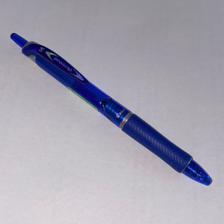

In [28]:
image

In [29]:
pred = model.predict(data={"data": image})

In [30]:
print(pred['classLabel'])

ballpoint, ballpoint pen, ballpen, Biro


### Decoding the prediction

In [31]:
output_layer_name = list(pred.keys())[1]
print("output layer:", output_layer_name)

output layer: resnetv27_dense0_fwd


In [32]:
pred_dict = pred[output_layer_name]

In [33]:
sorted_pred = [i for i in sorted(pred_dict.items(), key=lambda item: item[1], reverse=True)]

In [34]:
for l in sorted_pred[:5]:
    print(l)

('ballpoint, ballpoint pen, ballpen, Biro', 17.4841251373291)
('rubber eraser, rubber, pencil eraser', 12.197568893432617)
('fountain pen', 10.722954750061035)
('whistle', 8.942205429077148)
('pencil sharpener', 8.66175365447998)


Converting confidence to a meaningful value (using softmax):

In [35]:
import math

In [36]:
sum_exp = np.sum(np.exp(list(pred_dict.values())))

In [37]:
for l in [(i[0], math.exp(i[1])/sum_exp) for i in sorted_pred][:5]:
    print(l)

('ballpoint, ballpoint pen, ballpen, Biro', 0.9929359910561075)
('rubber eraser, rubber, pencil eraser', 0.005023414882465598)
('fountain pen', 0.0011496939937033455)
('whistle', 0.00019373703939148062)
('pencil sharpener', 0.00014635716910071583)
